# Qualtran + QREF & Bartiq

This notebook provides an example of converting Bloqs to [QREF](https://github.com/PsiQ/qref), then using QREF with [Bartiq](https://github.com/PsiQ/bartiq) for symbolic compilation.

The following is not meant to be an introduction to these packages and it is expected that the reader has a basic understanding of the functionality of each package. For more information about an individual package, please consult the respective documentation.

## Basics

**QREF** is a format for serializing quantum algorithms for the purpose of performing quantum resource estimations (QREs.)

**Bartiq** is a library for obtaining symbolic expressions for QREs. 

In order to highlight the benefits of the integration between Qualtran and QREF and Bartiq, we will analyze Alias Sampling – a state preparation method described in [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662).

Let's start with the basics: converting a Bloq to QREF, then compiling the costs using Bartiq.

### Use the Qualtran Alias Sampling Implementation

First, we will invoke the `StatePreparationAliasSampling` to generate a Bloq representing Alias Sampling method.

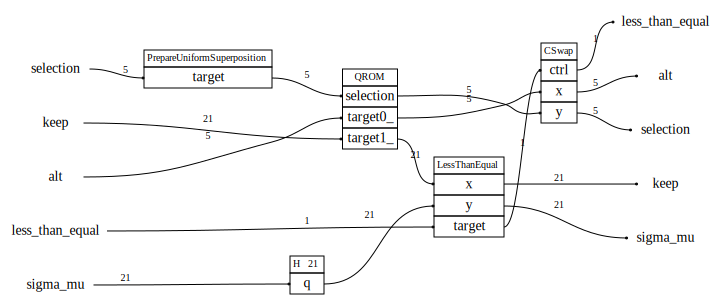

In [1]:
from qualtran.bloqs.state_preparation import StatePreparationAliasSampling
from qualtran.drawing.graphviz import PrettyGraphDrawer

probs_list = list(range(24))
bloq = StatePreparationAliasSampling.from_probabilities(probs_list).decompose_bloq()
PrettyGraphDrawer(bloq).get_svg()

### Convert the Bloq to QREF

Once you have a Bloq, converting it to QREF is easy with `bloq_to_qref`. We also print out the QREF object for easy comparison to the Bloq print out above.

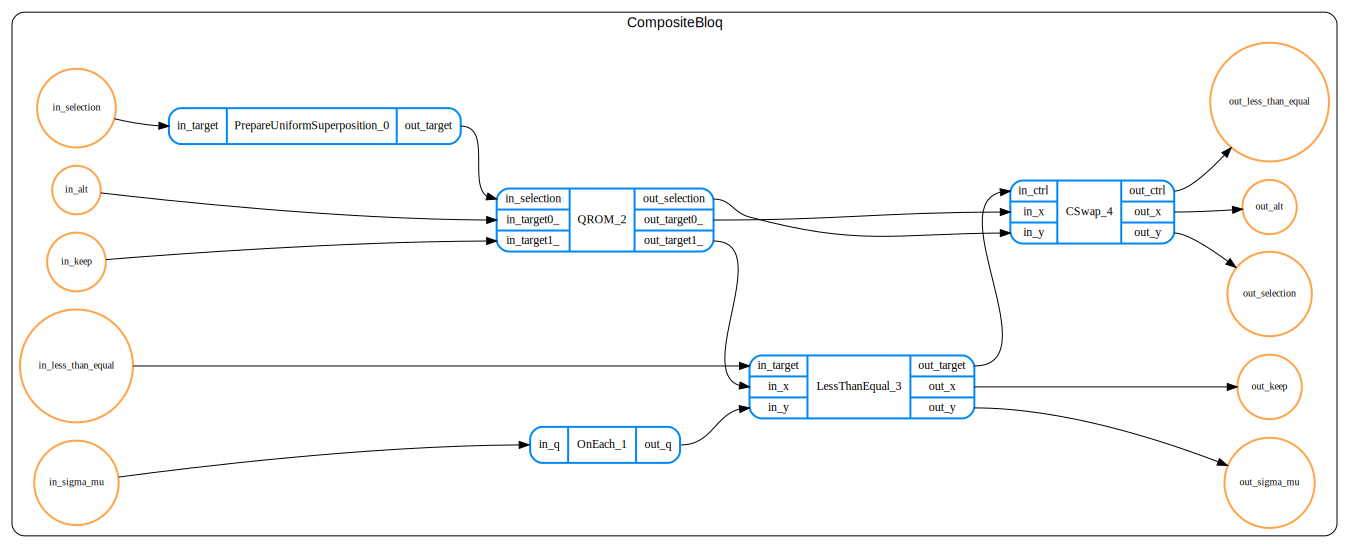

In [2]:
from qualtran.qref_interop import bloq_to_qref
from qref.experimental.rendering import to_graphviz

# We can easily convert it to QREF representation with the following code:
qref_definition = bloq_to_qref(bloq)
to_graphviz(qref_definition)

### Comparing Bloq and QREF Resources

Besides comparing the print outs of the two different objects above, it is helpful to review the cost details of the Bloq and QREF definition. 

In [3]:
from pprint import pprint
# We can check that the resources for both representations are the same:
print("Qualtran Bloq T Complexity: ")
pprint(bloq.t_complexity())
print("\nQREF Resources: ")
pprint(qref_definition.program.resources)

Qualtran Bloq T Complexity: 
TComplexity(t=307, clifford=1770, rotations=2)

QREF Resources: 
[ResourceV1(name='clifford', type='additive', value=1770),
 ResourceV1(name='rotations', type='additive', value=2),
 ResourceV1(name='t', type='additive', value=307)]


The resources printed above are the "top-level" resources. However, the resources of the building blocks can also be accessed. For example, Uniform State Preparation (`PrepareUniformSuperposition`) can be accessed with the following code:

In [4]:
USP_bloq = [bloq_inst.bloq for bloq_inst in bloq.bloq_instances if bloq_inst.bloq.pretty_name() == "PrepareUniformSuperposition"][0]
print("Qualtran PrepareUniformSuperposition T Complexity: ")
pprint(USP_bloq.t_complexity())
print("\n QREF PrepareUniformSuperposition_0 Resources: ")
pprint(qref_definition.program.children.by_name["PrepareUniformSuperposition_0"].resources)

Qualtran PrepareUniformSuperposition T Complexity: 
TComplexity(t=20, clifford=106, rotations=2)

 QREF PrepareUniformSuperposition_0 Resources: 
[ResourceV1(name='clifford', type='additive', value=106),
 ResourceV1(name='rotations', type='additive', value=2),
 ResourceV1(name='t', type='additive', value=20)]


### Use Bartiq with QREF to Compile the Costs 

The `qref_definition` can now be passed to Bartiq. However, it would be trivial since all of the resources are included from the Bloq. Therefore, before passing it to Bartiq, we will remove the "top-level" resources in `qref_definition`. After clearing the resources, calling `compile_routine` will compile the costs from the building blocks or subroutines.

In [5]:
from bartiq.integrations.qref import qref_to_bartiq
from bartiq import compile_routine


# Clear the resources from the top-level
qref_definition.program.resources =  [] 

bartiq_routine = qref_to_bartiq(qref_definition)
compiled_routine = compile_routine(bartiq_routine)

print("Qualtran Bloq T Complexity: ")
pprint(bloq.t_complexity())
print("\nQREF Resources:")
pprint(compiled_routine.resources)

Qualtran Bloq T Complexity: 
TComplexity(t=307, clifford=1770, rotations=2)

QREF Resources:
{'clifford': <Resource name="clifford" value="1770">,
 'rotations': <Resource name="rotations" value="2">,
 't': <Resource name="t" value="307">}


## Writing a Custom Uniform Superposition (USP) Implementation

While the example above demonstrated the integration, the information derived by Bartiq was the same as the information from Qualtran. Therefore, let's try other scenarios highlighting use cases where Bartiq can provide unique information.


### Numeric Implementation

The example above is purely numeric. If symbolic expressions are used, we are able to produce resources and decompose the "top-level" bloq, `StatePreparationAliasSampling` (see snippet below). However, subsequent bloqs, like `PrepareUniformSuperposition`, cannot be further decomposed using `decompose_bloq()` This is most likely temporary and as Qualtran improves, this might cease being a problem.

```
import sympy
N, M, eps = sympy.symbols("N M eps")
bloq = StatePreparationAliasSampling.from_n_coeff(n_coeff=N, sum_of_unnormalized_probabilites=M, precision=eps)
pprint(bloq.t_complexity())
```


### Resources Tied to a Specific Implementation

At the time of writing this, the source code of [PrepareUniformSuperposition](https://github.com/quantumlib/Qualtran/blob/c0a3a94d712f4eebb1cad119fc507a6cd9a7d8e7/qualtran/bloqs/state_preparation/prepare_uniform_superposition.py#L44), includes the following information in the docstring:

> Performs a single round of amplitude amplification and prepares a uniform superposition over the first $n$ basis states $|0>, |1>, ..., |n - 1>$. The expected T-complexity should be $10 * log(L) + 2 * K$ T-gates and $2$ single qubit rotation gates, where $n = L * 2^K$.
>
> However, the current T-complexity is $12 * log(L)$ T-gates and $2 + 2 * (K + log(L))$ rotations
because of two open issues:
> 
> - https://github.com/quantumlib/Qualtran/issues/233 and
> - https://github.com/quantumlib/Qualtran/issues/235


Unfortunately, in Qualtran there are instances of being tied to a specific implementation of a resource, even if it is known to be incorrect.

Below we will see how we can quickly create an alternative implementation of USP with QREF.

### Create the USP Implementation with Symbolic Expressions

First, we will create the Qualtran USP Bloq and then convert it to a QREF definition. We will do this to confirm the incorrect T-Complexity expressions.

In [6]:
from qualtran.bloqs.state_preparation import PrepareUniformSuperposition
import sympy

N = sympy.symbols("N")
USP_bloq = PrepareUniformSuperposition(N)

# We see that contrary to the docstring, the number of rotations is already correct
print("Qualtran USP Bloq T Complexity: ")
pprint(USP_bloq.t_complexity())

# Now we create a QREF definitions based on the PrepareUniformSuperposition bloq
usp_1_qref = bloq_to_qref(USP_bloq) # this will be left unchanged
print("\nQREF USP Resources: ")
pprint(usp_1_qref.program.resources)

Qualtran USP Bloq T Complexity: 
TComplexity(t=12*ceiling(log2(floor(N))) - 4, clifford=52*ceiling(log2(floor(N))) - 9, rotations=2)

QREF USP Resources: 
[ResourceV1(name='clifford', type='additive', value='52*ceiling(log2(floor(N))) - 9'),
 ResourceV1(name='rotations', type='additive', value='2'),
 ResourceV1(name='t', type='additive', value='12*ceiling(log2(floor(N))) - 4')]


We can see above that Bloq and QREF resources, for the USP have the same, incorrect symbolic expressions. From the docstring, we know that it should be $10 * log(L) + 2 * K$.

### Manually Create a New USP in QREF

We will implement the new version of USP directly in QREF with the correct expressions for the number of T gates and rotations. To fill in the other USP information we used the details from `usp_1_qref.model_dump()`. 

In [7]:
# Note that we omit Clifford gates here, as the expression for them is not mentioned in the docstring.
from qref import SchemaV1
import math
port_size = math.ceil(math.log2(len(probs_list)))

usp_2_qref = SchemaV1(
    program={
        "name": "PrepareUniformSuperposition",
        "input_params": ["N"],
        "ports": [
            {"direction": "input", "name": "in_target", "size": port_size},
            {"direction": "output", "name": "out_target", "size": port_size},
        ],
        "resources": [
            {"name": "t", "type": "additive", "value": "10*ceiling(log2(L)) + 2*k"},
            {"name": "rotations", "type": "additive", "value": "2"},
        ],
        "local_variables": {"k": "multiplicity(2, N)", "L": "N/2**k"},
    },
    version="v1",
)

Now that we have the QREF definition from both the Qualtran USP bloq and the manually created USP information, we can compare the symbolix expressions for the number of T gates.

In [8]:
usp_1_bartiq = qref_to_bartiq(usp_1_qref)
print("Qualtran USP Bloq T Complexity - T Gates")
pprint(compile_routine(usp_1_bartiq).resources["t"])

usp_2_bartiq = qref_to_bartiq(usp_2_qref)
print("\nQREF USP Custom Implementation - T Gates")
pprint(compile_routine(usp_2_bartiq).resources["t"])

Qualtran USP Bloq T Complexity - T Gates
<Resource name="t" value="12*ceiling(log2(floor(N))) - 4">

QREF USP Custom Implementation - T Gates
<Resource name="t" value="10*ceiling(log2(N/2 ^ multiplicity(2, N))) + 2*multiplicity(2, N)">


## Updating Alias Sampling

Now that we have a corrected USP component as a QREF definition, it is important to update Alias Sampling with the new component.

In [9]:
# Create the Alias Sampling bloq
bloq = StatePreparationAliasSampling.from_probabilities(probs_list).decompose_bloq()

# We export our Alias Sampling bloq to QREF and remove top-level resources so we can re-compute them later.
qref_as_1 = bloq_to_qref(bloq) # this will be left unchanged
qref_as_2 = bloq_to_qref(bloq) # this will be updated
qref_as_1.program.resources = []
qref_as_2.program.resources = []

print([child.name for child in qref_as_2.program.children])


['CSwap_4', 'LessThanEqual_3', 'OnEach_1', 'PrepareUniformSuperposition_0', 'QROM_2']


You will notice we printed out the names of the components of the Alias Sampling QREF defintion. This is important because before we put the subroutine in the right place, we need to make sure it is named correctly. If we failed to ensure the proper name, some of the connections will be invalid.

In [10]:
usp_2_qref.program.name = "PrepareUniformSuperposition_0"
qref_as_2.program.children.by_name["PrepareUniformSuperposition_0"] = usp_2_qref.program


bartiq_as_1 = qref_to_bartiq(qref_as_1)
print("Unchanged Alias Sampling T Complexity - T Gates: ")
pprint(compile_routine(bartiq_as_1).resources["t"])

bartiq_as_2 = qref_to_bartiq(qref_as_2)
print("\nUpdated Alias Sampling T Complexity - T Gates: ")
pprint(compile_routine(bartiq_as_2).resources["t"])


Unchanged Alias Sampling T Complexity - T Gates: 
<Resource name="t" value="307">

Updated Alias Sampling T Complexity - T Gates: 
<Resource name="t" value="10*ceiling(log2(PrepareUniformSuperposition_0.N/2 ^ multiplicity(2, PrepareUniformSuperposition_0.N))) + 2*multiplicity(2, PrepareUniformSuperposition_0.N) + 287">


/Users/briangoldsmith/anaconda3/envs/my-qualtran-env/lib/python3.11/site-packages/bartiq/compilation/_compile.py:117: UserWarning: Found the following issues with the provided routine after the compilation has finished: ["Input param N found in subroutine: CompositeBloq.PrepareUniformSuperposition_0, which is not among top level params: {'PrepareUniformSuperposition_0.N'}."]
  warnings.warn(


The unchanged Alias Sampling results shows the same 307 T gates that we saw earlier in the notebook. However, for the updated Alias Sampling, we see a much different result. While the T-gates resource is printed, a warning is also seen. Since the "top-level" routine does not have knowledge of its child's parameter, the parameter `N` from the USP routine is namespaced resulting in `PrepareUniformSuperposition_0.N` in the expression. To address the warning, at a "top-level" we will need to include `N` as an input paramter and link that to `PrepareUniformSuperposition_0.N`.

In [11]:
qref_as_2.program.input_params = ["N"]
qref_as_2.program.linked_params = [{"source": "N", "targets": ["PrepareUniformSuperposition_0.N"]}]

bartiq_as_2 = qref_to_bartiq(qref_as_2)
compiled_as_2 = compile_routine(bartiq_as_2)
compiled_as_2.resources["t"]

<Resource name="t" value="10*ceiling(log2(N/2 ^ multiplicity(2, N))) + 2*multiplicity(2, N) + 287">

With the `N` parameter correctly setup, we no longer see the warning and correctly compile and print the symbolic expression for the number of T gates. Now we can generate numerical values for the resources given a specific value of `N`. To do this, we can use Bartiq's `evaluate` method.

In [12]:
from bartiq import evaluate
N_value = len(probs_list)
assignments = {f"N={N_value}"}
evaluate(compiled_as_2, assignments).resources["t"]

<Resource name="t" value="313">

## Custom Cost Functions

Another case highlighting the usefulness of Bartiq is when the cost of a particular routine is given by a custom function. For example, we can set the cost of USP using a recursive function, `foo`, as defined below.

In [13]:
def foo(n):
    if n < 10:
        return n
    else:
        return foo(n-3) 

In [14]:
import copy
usp_3_qref = copy.copy(usp_2_qref)
usp_3_qref.program.resources = [{"name": "t", "type": "additive", "value": "2*foo(N)"}]

usp_3_bartiq = qref_to_bartiq(usp_3_qref)
compiled_usp_3 = compile_routine(usp_3_bartiq)
compiled_usp_3.resources

{'t': <Resource name="t" value="2*foo(N)">}

The function, `foo`, is now included in the cost expression for the number of T gates. Similar to what we did previously, by providing a value for `N` and mapping the function `foo` in the expression to the defined function `foo`, we can call `evaluate` to generate numerical values.

In [15]:
assignments = {"N=101"}
functions_map = {"foo": foo}
evaluate(compiled_usp_3, assignments, functions_map=functions_map).resources

{'t': <Resource name="t" value="16">}

Again, this highlights the power of Bartiq by allowing us to both use custom functions in the symbolic expressions for the costs, as well as evaluate them with specific numeric values.

## Closing Remarks

Thank you for going through this notebook!
QREF and Bartiq are still in beta, and there is so much more we could do to make the integration with Qualtran better.
If you have a specific use case in mind, or if you encounter any problems, please leave an issue in any of the involved projects. We'd love to help you make it work!